## Loading the packages

In [1]:
import os
import numpy as np

import utils.ImagesProcessor as ip
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import itertools


## Loading the datasets

In [2]:
def loadImages(directory_name):
    directory = os.fsencode(directory_name)
    imgs = []
    filenames = []
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.lower().endswith(".jpg"): 
            img = IP.readImage(directory_name + "/" + filename)
            img = IP.resizeImage(img, (1000, 1000))
            #chromaticity = IP.extractChromaticity(img)
            #colors_hist = np.array(IP.extractRGBHistogram(chromaticity))
            texture_features = np.array(IP.extractTexturefeatures(img))
            #img = img.reshape(-1)
            imgs.append(texture_features)
            filenames.append(filename)
    return np.array(imgs), filenames

In [57]:
TRAINING_PATH = "dataset_train"
NORMAL_PATH = "dataset_normal"
ANOMALY_PATH = "dataset_anomaly"
IP = ip.ImagesProcessor()

# Load the images
X_train, trainFilenames = loadImages(TRAINING_PATH)
X_normal, normalFilenames= loadImages(NORMAL_PATH)
X_anomaly, anomalyFilenames = loadImages(ANOMALY_PATH)

# Normalize them
X = np.append(np.append(X_train, X_normal, axis=0), X_anomaly, axis=0)
X_train = X_train.astype('float32')/X.max(axis=0)
X_normal = X_normal.astype('float32')/X.max(axis=0)
X_anomaly = X_anomaly.astype('float32')/X.max(axis=0)

/anaconda3/lib/python3.6/site-packages/skimage/feature/texture.py:109: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(image.dtype, np.float):


In [7]:
#print(X_train.shape)
#print(X_train)
#print(X_normal.shape)
#print(X_normal)
#print(X_anomaly.shape)
#print(X_anomaly)
#print(X)
#print(np.random.choice(X_train, int(len(X_train)*1)))

ValueError: a must be 1-dimensional

## Explore the Nu and Gamma parameters

In [50]:
def testSVM(nu=0.8, gamma=0.2, kernel="rbf", coef0=0, degree=3, sizeDataset=7):
    clf = svm.OneClassSVM(nu=nu, kernel=kernel, gamma=gamma, degree=degree, coef0=coef0)
    np.random.shuffle(X_train)
    clf.fit(X_train[0:sizeDataset])
    pred_ref = clf.predict(X_train)
    #print("ref:", pred_ref)
    #print(trainFilenames)
    pred_nor = clf.predict(X_normal)
    #print("normal:", pred_nor)
    #print(normalFilenames)
    pred_ano = clf.predict(X_anomaly)
    #print("anomalies:", pred_ano)
    #print(anomalyFilenames)
    return accuracy_score(np.append(pred_nor, pred_ano), [1]*len(pred_nor) + [-1]*len(pred_ano))
print(testSVM(0.2, 0.2))

0.7307692307692307


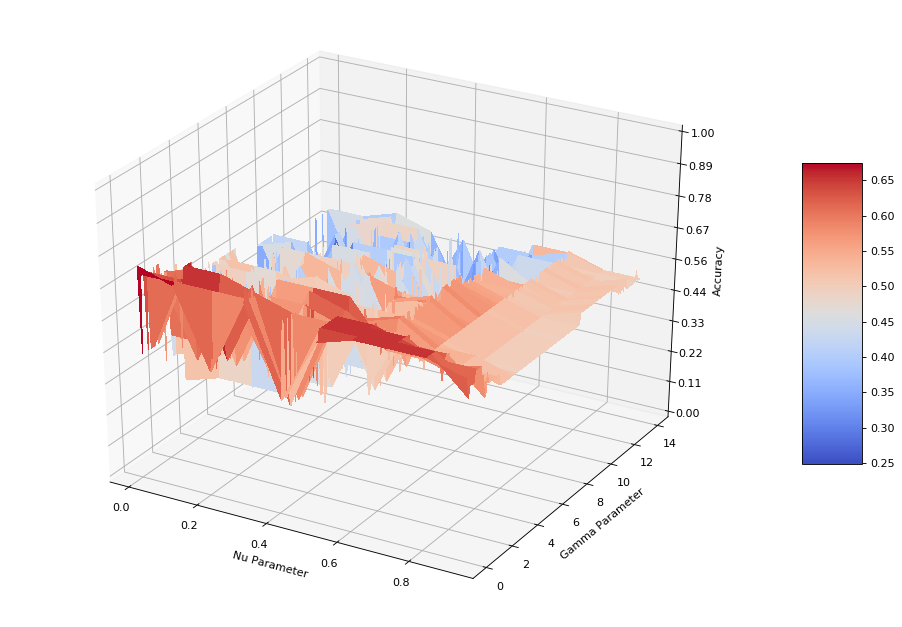

In [49]:
nu_params = np.arange(0.01,1.0,0.1)
gamma_params = np.arange(0.01,14.0,0.1)
#coef0_params = np.arange(0,50,1)
#degree_params = np.arange(1,7,1)

fig = plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
ax = fig.gca(projection='3d')
# Make data.
nu_params, gamma_params = np.meshgrid(nu_params, gamma_params)
#coef0_params, degree_params = np.meshgrid(coef0_params, degree_params)

accurencies = np.array([testSVM(nu=x,gamma=y, coef0=20, degree=4) for x,y in zip(np.ravel(nu_params), np.ravel(gamma_params))])
accurencies = accurencies.reshape(gamma_params.shape)

#accurencies = np.array([testSVM(coef0=x,degree=y, nu=0.5, gamma=0.166) for x,y in zip(np.ravel(coef0_params), np.ravel(degree_params))])
#accurencies = accurencies.reshape(degree_params.shape)

graph = ax.plot_surface(nu_params, gamma_params, accurencies, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

#ax.set_xlabel('Coef0 Parameter')
#ax.set_ylabel('Degree Parameter')

ax.set_xlabel('Nu Parameter')
ax.set_ylabel('Gamma Parameter')

ax.set_zlabel('Accuracy')

# Customize the z axis.
ax.set_zlim(0, 1.00)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(graph, shrink=0.5, aspect=5)

plt.show()

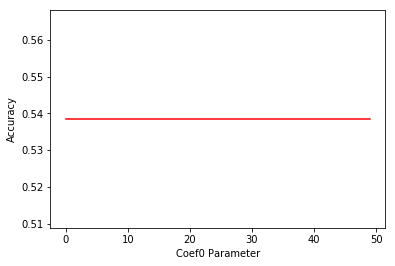

In [11]:
coef0_params = np.arange(0,50,1)
fig, axes = plt.subplots()
accurencies = np.array([testSVM(nu=0.75, gamma=4, coef0=x) for x in coef0_params])
graph = axes.plot(coef0_params, accurencies, 'r')
axes.set_xlabel('Coef0 Parameter')
axes.set_ylabel('Accuracy')
plt.show()

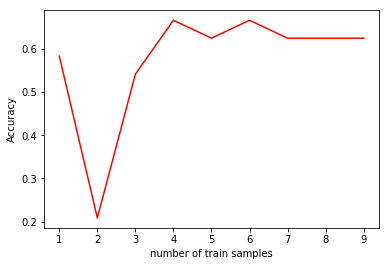

In [26]:
datasetSize = np.arange(1,10,1)
fig, axes = plt.subplots()
accurencies = np.array([testSVM(nu=0.75, gamma=0.3, sizeDataset=x) for x in datasetSize])
graph = axes.plot(datasetSize, accurencies, 'r')
axes.set_xlabel('number of train samples')
axes.set_ylabel('Accuracy')
plt.show()

## Final Model

In [58]:
clf = svm.OneClassSVM(nu=0.2, kernel="rbf", gamma=0.2)
clf.fit(X_train)
pred_ref = clf.predict(X_train)
pred_nor = clf.predict(X_normal)
pred_ano = clf.predict(X_anomaly)

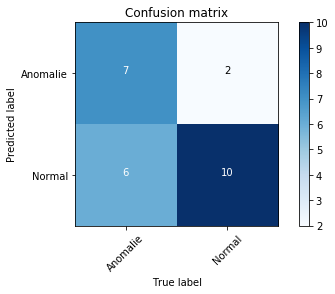

In [59]:
conf_mat = confusion_matrix(np.append(pred_nor, pred_ano), [1]*len(pred_nor) + [-1]*len(pred_ano))

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):     
    labels_names_ref = ["Anomalie", "Normal"]
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels_names_ref))
    plt.xticks(tick_marks, labels_names_ref, rotation=45)
    plt.yticks(tick_marks, labels_names_ref)
    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
plot_confusion_matrix(conf_mat)

In [55]:
print("Accuracy:", accuracy_score(np.append(pred_nor, pred_ano), [1]*len(pred_nor) + [-1]*len(pred_ano)))
precision = (conf_mat[0][0]/(conf_mat[0][0] + conf_mat[1][0]) + conf_mat[1][1]/(conf_mat[1][1] + conf_mat[0][1]))/2
print("Precision: ", precision)
recall = (conf_mat[0][0]/(conf_mat[0][0] + conf_mat[0][1]) + conf_mat[1][1]/(conf_mat[1][1] + conf_mat[1][0]))/2
print("Recall: ", recall)
f1score = 2*(precision*recall)/(precision+recall)
print("F1-Score: ", f1score)

Accuracy: 0.7307692307692307
Precision:  0.7321428571428572
Recall:  0.7307692307692308
F1-Score:  0.731455399061033


In [60]:
for i in range(len(anomalyFilenames)):
    print(anomalyFilenames[i], " - ", pred_ano[i])

A_0254.jpg  -  -1
A_0255.jpg  -  -1
A_0241.jpg  -  1
A_0257.jpg  -  -1
A_0242.jpg  -  1
A_0256.jpg  -  1
A_0253.jpg  -  -1
A_0251.jpg  -  -1
A_0236.jpg  -  1
A_0205.jpg  -  1
A_0248.jpg  -  1
A_0258.jpg  -  -1
A_0259.jpg  -  -1
